In [1]:
#%matplotlib widget 
import sys
import numpy as np
import mpi4py
import os

from pyDFCSR_2D import CSR2D
import matplotlib.pyplot as plt
from matplotlib import cm
import h5py

from pyDFCSR_2D.tools import plot_surface

import pickle
import os
import re
import shutil
import h5py

[nid008325:586436] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.nid008325.104522/jf.0/3523674112/shared_mem_cuda_pool.nid008325 could be created.
[nid008325:586436] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


<HDF5 dataset "z": shape (100000,), type "<f8">


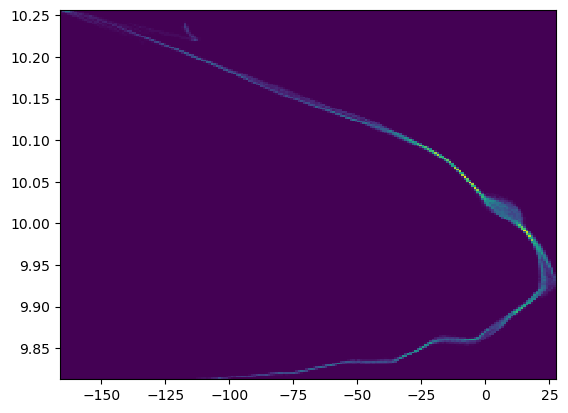

In [8]:
init_beams_dir = '//global/cfs/cdirs/m669/obed/w_chicane_pydf_outputs/';
beamfile = 'test_beam-particles-end.h5';
with h5py.File(init_beams_dir + beamfile, 'r') as beam:
    print(beam['position']['z'])
    plt.hist2d(1e6*beam['position']['z'][:], beam['momentum']['z'][:]/1e9, 200);

In [22]:
beam_stats = {}
stats_file = 'test_beam-statistics.h5'
with h5py.File(init_beams_dir + stats_file, 'r') as stats:
    print(stats.keys() )
    for key in stats.keys():
        print(type( stats[key]  ) )

<KeysViewHDF5 ['coords', 'mean_energy', 'mean_x', 'mean_z', 'n_vec', 'sigma_energy', 'sigma_x', 'sigma_z', 'slope', 'step_positions', 'tau_vec', 'twiss']>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.group.Group'>


In [24]:
import h5py
import numpy as np

def h5_to_dict(h5_file):
    """Recursively convert an HDF5 file into a Python dictionary."""
    def recursively_convert(group):
        result = {}
        for key in group:
            item = group[key]
            if isinstance(item, h5py.Group):
                result[key] = recursively_convert(item)
            elif isinstance(item, h5py.Dataset):
                result[key] = item[()]  # Convert dataset to numpy array, or item[:]
            else:
                result[key] = str(item)  # For other types, convert to string
        return result

    with h5py.File(h5_file, 'r') as file:
        return recursively_convert(file)

# Example usage
h5_file_path = init_beams_dir + stats_file # Replace with your HDF5 file path
stats_dict = h5_to_dict(h5_file_path)


In [26]:
stats_dict.keys()

dict_keys(['coords', 'mean_energy', 'mean_x', 'mean_z', 'n_vec', 'sigma_energy', 'sigma_x', 'sigma_z', 'slope', 'step_positions', 'tau_vec', 'twiss'])

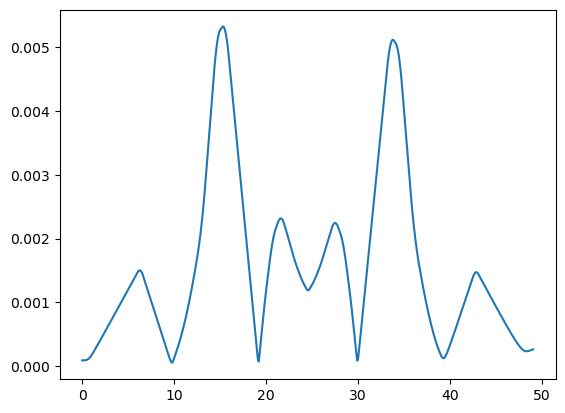

In [45]:
plt.plot(stats_dict['step_positions'][:-1] , stats_dict['sigma_x'][:-1])

In [3]:
# For modifying config programatically
def replace_config_content(config_path, keyword, replacement_string):
    """
    Replace content after 'keyword:' in the line starting with keyword: in the given file.

    Args:
    - filepath (str): Path to the text file.
    - replacement_string (str): String to replace the content after 'beamfile:'.

    Returns:
    - bool: True if the replacement was successful, False otherwise.
    """
    filepath = config_path;
    try:
        # Read the file line by line
        with open(filepath, 'r') as file:
            lines = file.readlines()

        # Define the keyword to search for
        keyword = '  ' + keyword;

        # Iterate through the lines
        for i, line in enumerate(lines):
            if line.startswith(keyword):
                # Find the position of 'beamfile:'
                index = line.find(keyword)
                
                # Replace everything after 'beamfile:' with replacement_string
                lines[i] = line[:index + len(keyword)] + ' ' + replacement_string + '\n'  # Include newline if needed
                break  # Assuming only one line starts with '  beamfile:'

        # Write the modified lines back to the file
        with open(filepath, 'w') as file:
            file.writelines(lines)

        return True  # Return True if successful

    except Exception as e:
        print(f"Error occurred: {e}")
        return False  # Return False if there was an error

In [4]:
lattice_names = ['bc202_c', 'ff_1_exp_ip']

## Prepare input beam from bmad output

In [23]:
bmad_path = '/global/homes/o/ocamacho/impact_bmad_container_notebooks/Sol_Scan_FACET/1.6nC_s2e_100k/bmadcsron-17.0_-41.5.pkl'
print(bmad_path)
with open(bmad_path, 'rb') as file:
    P = pickle.load(file)['P'][0];
    #print("Great success!")
    #print(dir(P) )
    #print(P.norm_emit_y)
    dir_path = '/global/cfs/cdirs/m669/obed/begbc20_beams/'
    filename = 'test_beam.h5'
    # Write beam object to working dir
    P.write(dir_path + filename);
    print(dir_path + filename)

/global/homes/o/ocamacho/impact_bmad_container_notebooks/Sol_Scan_FACET/1.6nC_s2e_100k/bmadcsron-17.0_-41.5.pkl
/global/cfs/cdirs/m669/obed/begbc20_beams/test_beam.h5


In [57]:
input_dir = '/global/cfs/projectdirs/m669/obed/begbc20_beams/'
phi1 = '-17.0'; phi2 = '-41.5'
init_beam = input_dir + 'test_beam.h5'
init_config = '/global/homes/o/ocamacho/pydfCSR_sims/config_files/W_chicane_config_base_-18.0_-41.0.yaml';
#r'/global/homes/o/ocamacho/pydfCSR_sims/config_files/W_chicane_config_base.yaml';
output_dir =  '/global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/'

In [58]:
init_config

'/global/homes/o/ocamacho/pydfCSR_sims/config_files/W_chicane_config_base_-18.0_-41.0.yaml'

In [59]:
init_beam

'/global/cfs/projectdirs/m669/obed/begbc20_beams/test_beam.h5'

In [60]:
with h5py.File(init_beam, 'r+') as beam:
    mc2 = 510998.946 # Electron rest mass in eV
    tArr = beam['time']
    tRef = np.mean(tArr);
    dtArr = tArr - tRef;
    PxArr = beam['momentum']['x'][:];
    PyArr = beam['momentum']['y'][:];
    PzArr = beam['momentum']['z'][:];
    #print(beam['position']['z'])
    #print(np.mean(pzArr/1e6) )
    gbzArr = PzArr/mc2;
    #print(np.mean(gbzArr) ) ;
    B = gbzArr/(1 + gbzArr**2);
    B *= (PxArr/PzArr)**2 + (PyArr/PzArr)**2;
    B += 1.000;
    betazArr = gbzArr/np.sqrt(1 + gbzArr**2)/np.sqrt(B);
    betaRef = np.mean(betazArr)
    
    
    zArr = -betazArr * 299792458 * dtArr;

    
    if 'z' in  beam['position']:
        # Remove the existing 'z' group if it's there
        del beam['position']['z']
    
        # Create a new dataset for 'z' under 'position'
        z_dataset = beam['position'].create_dataset('z', data=zArr, shape=zArr.shape, dtype=zArr.dtype)
    
    #print(beam['position']['z'])
    
    

## LOAD

In [61]:
# Bmad tracking for comparison

import pickle;

path_to_bmad =  r'/global/homes/o/ocamacho/impact_bmad_container_notebooks/Sol_Scan_FACET/1.6nC_s2e_100k/bmad_test_beam.pkl';# r'/global/homes/o/ocamacho/impact_bmad_container_notebooks/Sol_Scan_FACET/1.6nC_s2e_100k/bmad-_-17.0_-41.5.pkl'
with open(path_to_bmad, 'rb') as file:
    data = pickle.load(file);
    print(data.keys())
    
    s_0 = data['s']
    eta_x_0 = data['eta_x']
    beta_x_0 = data['beta_x']
    beta_y_0 = data['beta_y']
    sigma_z_0 = data['sigma_z']
    sigma_x_0 = data['sigma_x']
    sigma_y_0 = data['sigma_y']
    eta_xp_0 = data['sigma61'];
    cent_0 = data['cent'];
    P = data['P']

dict_keys(['beta_y', 'beta_x', 'etot', 'eta_y', 'eta_x', 'sigma_x', 'sigma_y', 'pc', 'cent', 'sigma61', 'sigma_z', 's', 'idx', 'P'])


In [62]:
# Fix offsets to match
avgt = P[0].t.mean(); avgpz = P[0].pz.mean();

avgx = P[0].x.mean(); avgxp = P[0].px.mean()/avgpz;

avgy = P[0].y.mean(); avgyp = P[0].py.mean()/avgpz;


avgz = 299792458*P[0].t.mean();

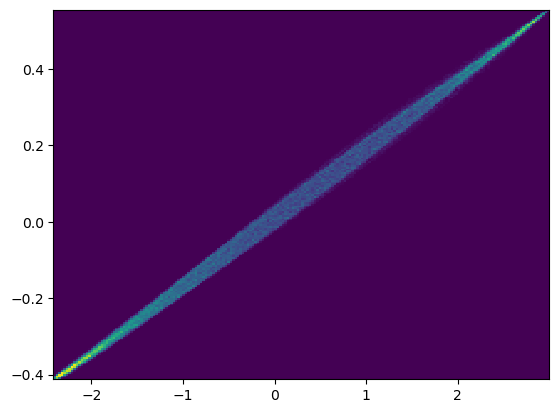

In [63]:
plt.hist2d(1e3*P[2].x, 1e3*P[2].px/P[2].pz.mean(), 200);

with h5py.File(init_beam, 'r+') as beam_file:
    ####################################
    dataset = beam_file['x']
    data = dataset[()]
    data -= avgx
    dataset[...] = data
    
    dataset = beam_file['xp']
    data = dataset[()]
    data -= avgxp
    dataset[...] = data
    #########################
    dataset = beam_file['y']
    data = dataset[()]
    data -= avgy
    dataset[...] = data
    
    dataset = beam_file['yp']
    data = dataset[()]
    data -= avgyp
    dataset[...] = data
    #################################
    dataset = beam_file['zeta']
    data = dataset[()]
    data -= avgz
    dataset[...] = data

In [64]:
testCompression = CSR2D(input_file= init_config)
testCompression.CSR_params.apply_CSR = 0;
testCompression.CSR_params.compute_CSR = 0;
testCompression.CSR_params.transverse_on = 0;

start reinterpolation. number of slice 1
xbins = 500  zbins =  500


### Plot Initial Phase Space

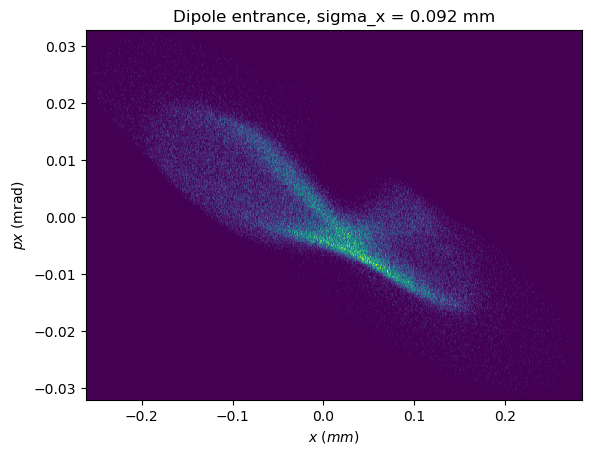

In [65]:
plt.hist2d( 1e3*(testCompression.beam.x),  1e3*testCompression.beam.px, 500);
plt.xlabel(r'$x$ ($m m$)'); plt.ylabel('$px$ (mrad)');
plt.title(f'Dipole entrance, sigma_x = {1e3*testCompression.beam.x.std():.3f} mm');

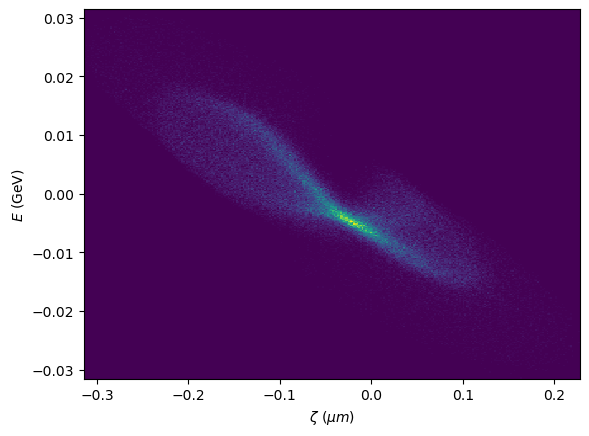

In [66]:
plt.hist2d( 1e3*P[0].x  , 1e3*( P[0].px )/P[0].pz.mean(), 300);
plt.xlabel(r'$\zeta$ ($\mu m$)'); plt.ylabel('$E$ (GeV)');

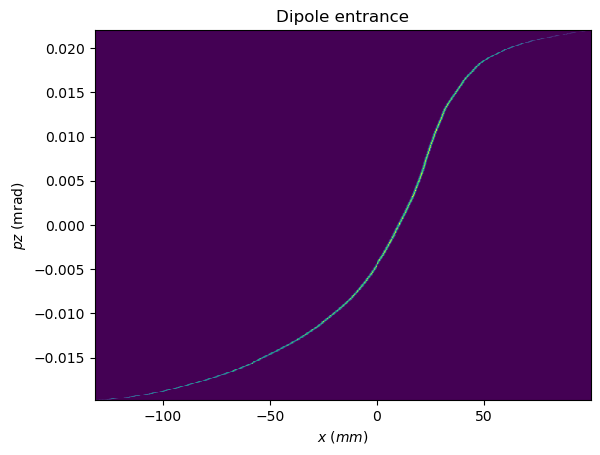

In [67]:
plt.hist2d( 1e6*(testCompression.beam.z),  testCompression.beam.pz, 500);
plt.xlabel(r'$x$ ($m m$)'); plt.ylabel('$pz$ (mrad)');
plt.title(f'Dipole entrance');

925.4098903297211
-8847.791355340689


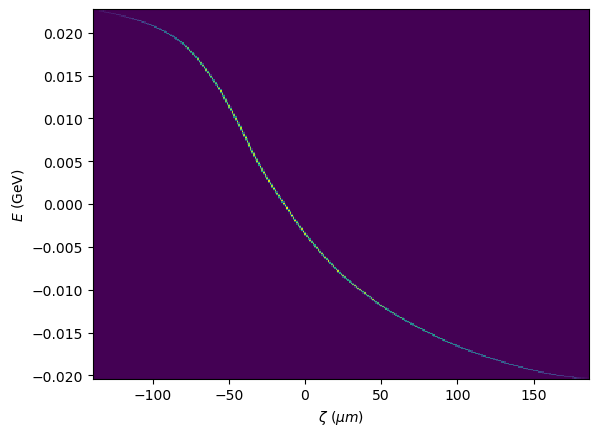

In [68]:
plt.hist2d( 1e6*3e8*(P[0].t - np.mean(P[0].t)  ),  P[0].pz/P[0].pz.mean() - 1, 300);
plt.xlabel(r'$\zeta$ ($\mu m$)'); plt.ylabel('$E$ (GeV)');
print( 299792458*np.mean(P[0].t) )
print( np.mean(P[0].px) )

In [69]:
%%time

# Run through lattice
testCompression.run();

Starting the DFCSR run
Drift(L=0.0001)
SBend(L=0.0999, P0C=10008433689.033918, G=0.021250112621849206, DG=0.0, E1=0.011294675, E2=0.0, FINT=0.5, HGAP=0.0115, FINTX=0.5, HGAPX=0.0115, FRINGE_AT='both_ends', FRINGE_TYPE='linear_edge', TILT=0.0)
Finish step 1, s = 0.1,  in 0.22867631912231445 seconds
SBend(L=0.1, P0C=10008433689.033918, G=0.021250112621849206, DG=0.0, E1=0.0, E2=0.0, FINT=0.5, HGAP=0.0115, FINTX=0.5, HGAPX=0.0115, FRINGE_AT='both_ends', FRINGE_TYPE='linear_edge', TILT=0.0)
Finish step 2, s = 0.2,  in 0.2090606689453125 seconds
SBend(L=0.1, P0C=10008433689.033918, G=0.021250112621849206, DG=0.0, E1=0.0, E2=0.0, FINT=0.5, HGAP=0.0115, FINTX=0.5, HGAPX=0.0115, FRINGE_AT='both_ends', FRINGE_TYPE='linear_edge', TILT=0.0)
Finish step 3, s = 0.30000000000000004,  in 0.2029261589050293 seconds
SBend(L=0.1, P0C=10008433689.033918, G=0.021250112621849206, DG=0.0, E1=0.0, E2=0.0, FINT=0.5, HGAP=0.0115, FINTX=0.5, HGAPX=0.0115, FRINGE_AT='both_ends', FRINGE_TYPE='linear_edge', TILT=0

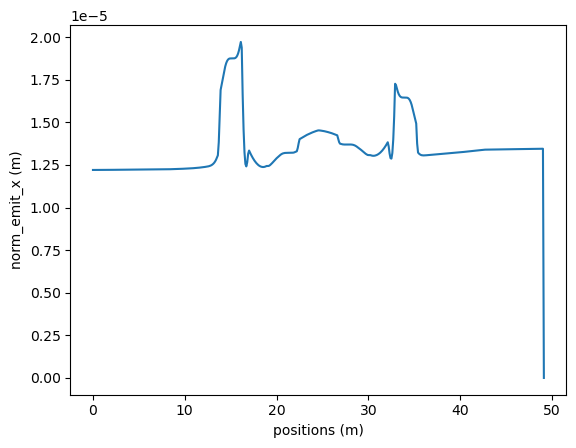

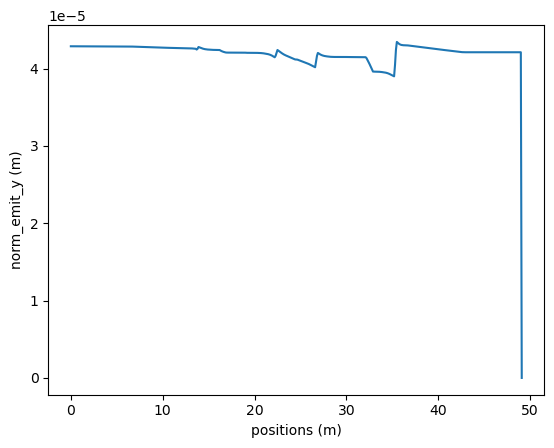

In [70]:
from pyDFCSR_2D.postprocessor import DFCSR_postprocessor

DFplot = DFCSR_postprocessor(run_name = 'BEGBC20_1M_-17.0_-37.5_pydf_out',
                             work_dir = '/global/cfs/projectdirs/m669/obed/w_chicane_pydf_outputs/')
s, eta_x = DFplot.get_statistics(key = 'eta_x', show_plot = False);
s, beta_x = DFplot.get_statistics(key = 'beta_x', show_plot = False);
s, beta_y = DFplot.get_statistics(key = 'beta_y', show_plot = False);
s, sigma_z = DFplot.get_statistics(key = 'sigma_z', show_plot = False);
s, sigma_x = DFplot.get_statistics(key = 'sigma_x', show_plot = False);
s, eta_xp = DFplot.get_statistics(key = 'etap_x', show_plot = False);
s, eps_n_x = DFplot.get_statistics(key = 'norm_emit_x', show_plot = True);
s, eps_n_y = DFplot.get_statistics(key = 'norm_emit_y', show_plot = True);
s, avg_x = DFplot.get_statistics(key = 'mean_x', show_plot = False);

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1682256/1179357537.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(s_0[idx:idx + n_step] - s_0[idx], beta_x_0[idx: idx + n_step]**0.50, label = '$\sqrt{ bx}$ (BMAD)', c = 'orange',linestyle = '-.')
/tmp/ipykernel_1682256/1179357537.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.scatter(s_0[idx:idx + n_step] - s_0[idx], beta_x_0[idx: idx + n_step]**0.50, label = '$\sqrt{ bx}$ (BMAD)', c = 'orange', s = 5)#linestyle = '-.')
/tmp/ipykernel_1682256/1179357537.py:7: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(s[:-1], beta_x[:-1]**0.50, label = '$\sqrt

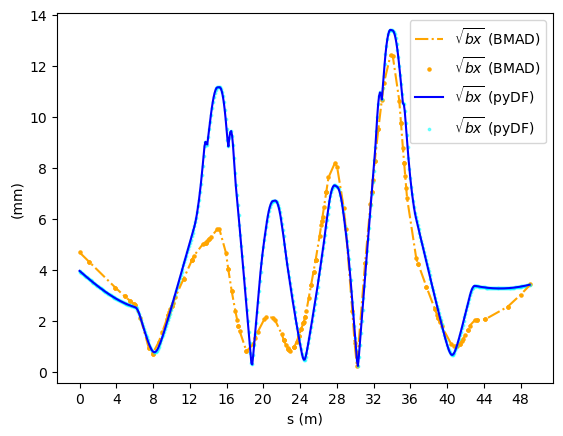

In [71]:
idx = 1293;
n_step = 170
plt.plot(s_0[idx:idx + n_step] - s_0[idx], beta_x_0[idx: idx + n_step]**0.50, label = '$\sqrt{ bx}$ (BMAD)', c = 'orange',linestyle = '-.')
plt.scatter(s_0[idx:idx + n_step] - s_0[idx], beta_x_0[idx: idx + n_step]**0.50, label = '$\sqrt{ bx}$ (BMAD)', c = 'orange', s = 5)#linestyle = '-.')
#plt.scatter(s_0[idx:idx + n_step] - s_0[idx], 1e4*eta_x_0[idx: idx + n_step], label = '$\eta_x$ (BMAD)', c = 'orange', linestyle = '-.', alpha = 0.50)

plt.plot(s[:-1], beta_x[:-1]**0.50, label = '$\sqrt{ bx }$ (pyDF)', c = 'blue')
plt.scatter(s[:-1], beta_x[:-1]**0.50, label = '$\sqrt{ bx }$ (pyDF)', s = 3, c = 'cyan', alpha = 0.50)
plt.xlabel('s (m)')
plt.ylabel('(mm)')
plt.legend();
#plt.xlim(0, 20);
plt.xticks(range(0, 50, 4));

/tmp/ipykernel_1682256/857182984.py:1: RuntimeWarning: invalid value encountered in divide
  eps = (sigma_x_0**2 / beta_x_0)[1293:1293+170];


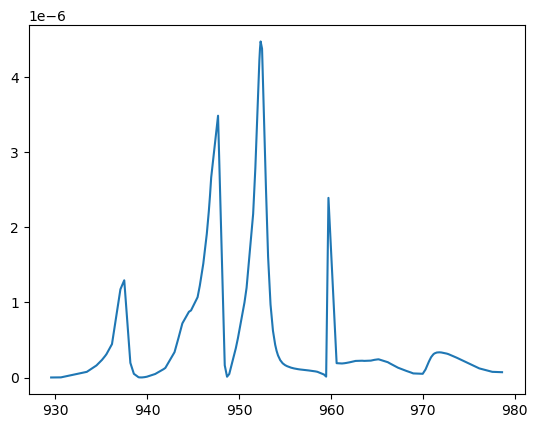

In [72]:
eps = (sigma_x_0**2 / beta_x_0)[1293:1293+170];
plt.plot(s_0[1293:1293+170], eps)
#plt.plot(s, eps_n_x)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1682256/787663558.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(s_0[idx:idx + n_step] - s_0[idx], beta_y_0[idx: idx + n_step]**0.50, label = '$\sqrt{ by}$ (BMAD)', c = 'orange',linestyle = '-.')
/tmp/ipykernel_1682256/787663558.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.scatter(s_0[idx:idx + n_step] - s_0[idx], beta_y_0[idx: idx + n_step]**0.50, label = '$\sqrt{ by}$ (BMAD)', c = 'orange', s = 5)#linestyle = '-.')
/tmp/ipykernel_1682256/787663558.py:7: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(s[:-1], beta_y[:-1]**0.50, label = '$\sqrt{ b

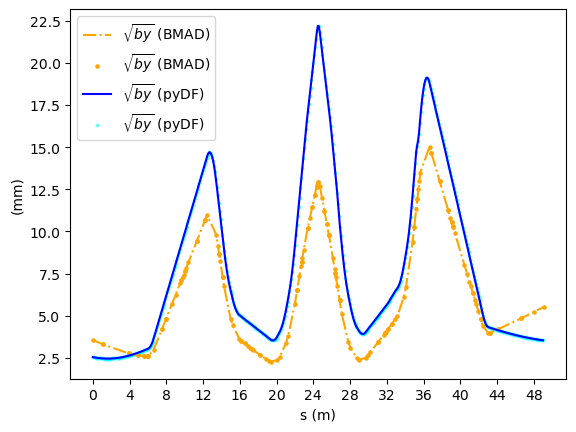

In [73]:
idx = 1293;
n_step = 170
plt.plot(s_0[idx:idx + n_step] - s_0[idx], beta_y_0[idx: idx + n_step]**0.50, label = '$\sqrt{ by}$ (BMAD)', c = 'orange',linestyle = '-.')
plt.scatter(s_0[idx:idx + n_step] - s_0[idx], beta_y_0[idx: idx + n_step]**0.50, label = '$\sqrt{ by}$ (BMAD)', c = 'orange', s = 5)#linestyle = '-.')
#plt.scatter(s_0[idx:idx + n_step] - s_0[idx], 1e4*eta_x_0[idx: idx + n_step], label = '$\eta_x$ (BMAD)', c = 'orange', linestyle = '-.', alpha = 0.50)

plt.plot(s[:-1], beta_y[:-1]**0.50, label = '$\sqrt{ by }$ (pyDF)', c = 'blue')
plt.scatter(s[:-1], beta_y[:-1]**0.50, label = '$\sqrt{ by }$ (pyDF)', s = 3, c = 'cyan', alpha = 0.50)
plt.xlabel('s (m)')
plt.ylabel('(mm)')
plt.legend();
#plt.xlim(0, 20);
plt.xticks(range(0, 50, 4));

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1682256/3405156332.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(s[:-1], 1e3*sigma_x[:-1], label = '$\sigma_x$ (pyDF)', c = 'blue', linestyle = '-.');
/tmp/ipykernel_1682256/3405156332.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.scatter(s_0[idx:idx + n_step] - s_0[idx], 1e3*sigma_x_0[idx: idx + n_step], label = '$\sigma_{x}$ (BMAD)', c = 'orange', s = 10);#linestyle = '-.')


0.0000mm vs 0.1802mm 


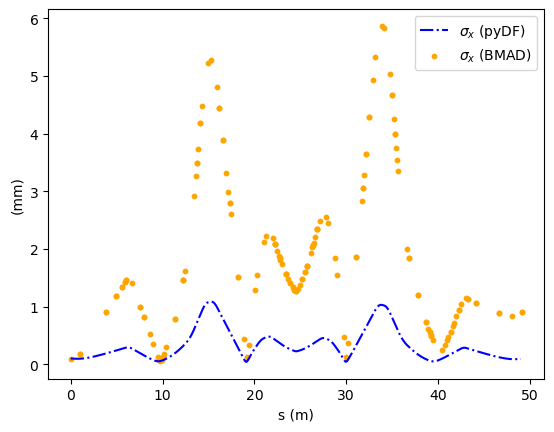

In [74]:
idx = 1293;
n_step = 171
plt.plot(s[:-1], 1e3*sigma_x[:-1], label = '$\sigma_x$ (pyDF)', c = 'blue', linestyle = '-.');
plt.scatter(s_0[idx:idx + n_step] - s_0[idx], 1e3*sigma_x_0[idx: idx + n_step], label = '$\sigma_{x}$ (BMAD)', c = 'orange', s = 10);#linestyle = '-.')
plt.xlabel('s (m)');
plt.ylabel('(mm)');
#plt.xlim(0, 3.0);
#plt.xticks(range(0, 2, 1));
#plt.ylim(0.00,  0.80);
print(f"{1e3*sigma_x[-1]:.4f}mm vs {1e3*sigma_x_0[idx+1]:.4f}mm ")
plt.legend();

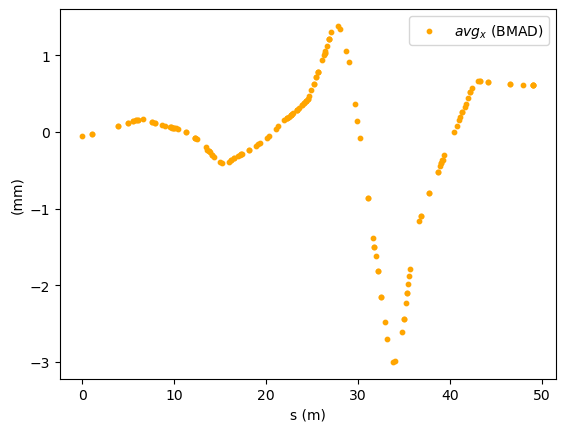

In [75]:
idx = 1293;
n_step = 173
#plt.plot(s[0:-1] - s[0], 1e3*avg_x[0:-1], label = '$avg_x$ (pyDF)', c = 'blue', linestyle = '-.');
plt.scatter(s_0[idx:idx + n_step] - s_0[idx], 1e3*cent_0[idx: idx + n_step], label = '$avg_{x}$ (BMAD)', c = 'orange', s = 10);#linestyle = '-.')
plt.xlabel('s (m)');
plt.ylabel('(mm)');
#plt.xlim(0, 3.0);
#plt.xticks(range(0, 2, 1));
#plt.ylim(0.00,  0.80);
#print(f"{1e3*sigma_x[-1]:.4f}mm vs {1e3*sigma_x_0[idx+1]:.4f}mm ")
plt.legend();

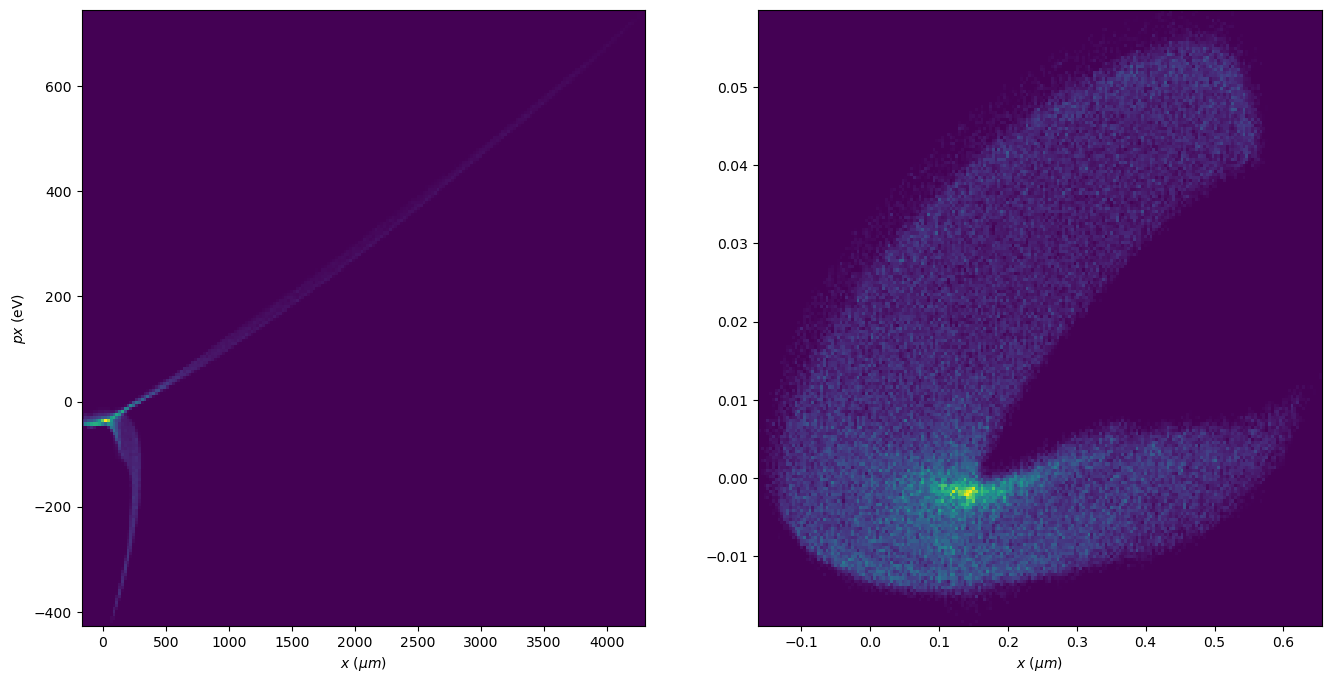

In [76]:
fig, ax  = plt.subplots(1,2, figsize = (16,8) );
ax[0].hist2d( 1e6*P[-1].x,  1e6*P[-1].px/P[0].energy, 200);
ax[0].set_xlabel(r'$x $ ($\mu m $)'); ax[0].set_ylabel('$px$ (eV)');
#ax[0].set_xlim(-100, 650); ax[0].set_ylim(-2e5, 3e5); 

ax[1].hist2d(1e3*(testCompression.beam.x ),  1e3*testCompression.beam.px , 200);
ax[1].set_xlabel(r'$x$ ($\mu m$)'); ax[0].set_ylabel('$px$ (eV)');
#ax[1].set_xlim(-100, 650); ax[1].set_ylim(-2e5, 3e5); 

Text(0.5, 1.0, 'Dipole exit, sigma_x = 0.170 mm')

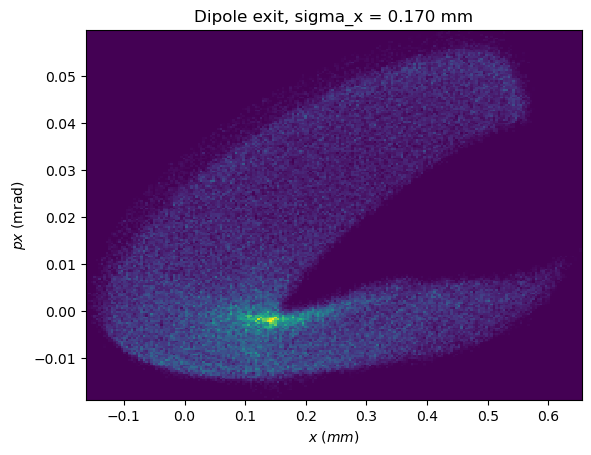

In [77]:
plt.hist2d(1e3*(testCompression.beam.x ),  1e3*testCompression.beam.px , 200);
plt.xlabel(r'$x$ ($mm$)'); plt.ylabel('$px$ (mrad)');
#ax[1].set_xlim(-100, 650); ax[1].set_ylim(-2e5, 3e5); 
plt.title(f'Dipole exit, sigma_x = {1e3*testCompression.beam.x.std():.3f} mm')

<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_1682256/1337448369.py:1: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(s_0[idx:idx + n_step] - s_0[idx], eta_x_0[idx: idx + n_step], label = '$\eta_x$ (BMAD)', c = 'orange', linestyle = '-.')
/tmp/ipykernel_1682256/1337448369.py:2: SyntaxWarning: invalid escape sequence '\e'
  plt.scatter(s_0[idx:idx + n_step] - s_0[idx], eta_x_0[idx: idx + n_step], label = '$\eta_x$ (BMAD)', c = 'orange', linestyle = '-.', alpha = 0.50)
/tmp/ipykernel_1682256/1337448369.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(s, eta_x, label = '$\eta_x$ (pyDF)', c = 'blue')


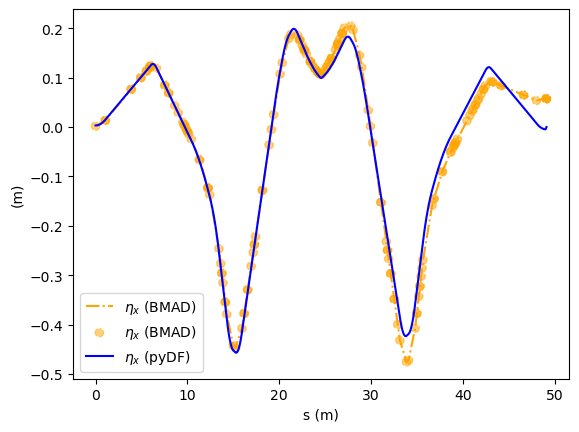

In [78]:
plt.plot(s_0[idx:idx + n_step] - s_0[idx], eta_x_0[idx: idx + n_step], label = '$\eta_x$ (BMAD)', c = 'orange', linestyle = '-.')
plt.scatter(s_0[idx:idx + n_step] - s_0[idx], eta_x_0[idx: idx + n_step], label = '$\eta_x$ (BMAD)', c = 'orange', linestyle = '-.', alpha = 0.50)

plt.plot(s, eta_x, label = '$\eta_x$ (pyDF)', c = 'blue')
plt.xlabel('s (m)')
plt.ylabel('(m)')
plt.legend();

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1682256/1604376770.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(s[:-1], 1e6*sigma_z[:-1], label = '$\sigma_z$ (pyDF)', c = 'blue')
/tmp/ipykernel_1682256/1604376770.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$(\mu m)$')


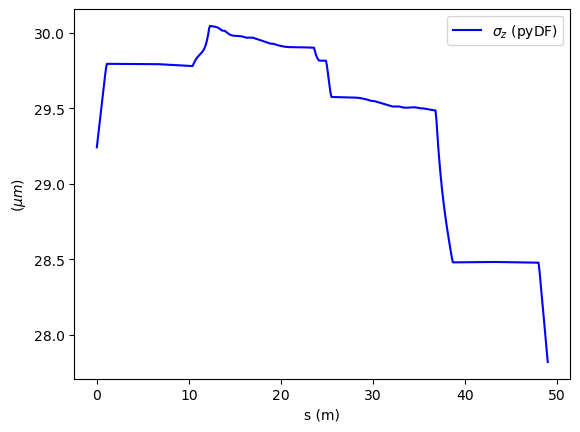

In [79]:
#plt.plot(s_0[idx:idx + n_step] - s_0[idx], 1e6*sigma_z_0[idx: idx + n_step], label = '$\sigma_z$ (BMAD)', c = 'orange')#, linestyle = '-.')
#plt.scatter(s_0[idx:idx + n_step] - s_0[idx], 1e6*sigma_z_0[idx: idx + n_step], label = '$\sigma_z$ (BMAD)', c = 'orange')#, linestyle = '-.')

plt.plot(s[:-1], 1e6*sigma_z[:-1], label = '$\sigma_z$ (pyDF)', c = 'blue')
plt.xlabel('s (m)')
plt.ylabel('$(\mu m)$')
plt.legend();

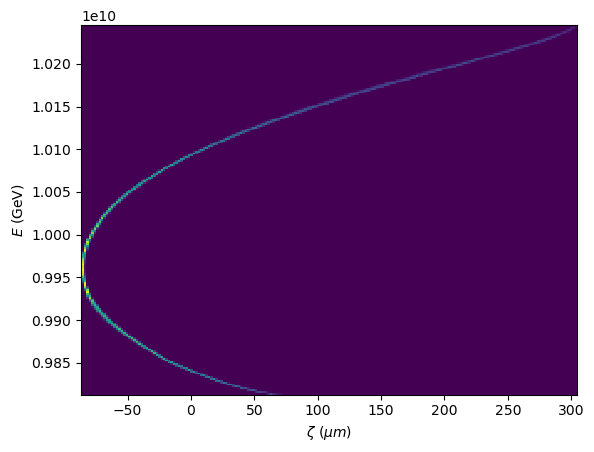

In [80]:
plt.hist2d( 3e8*1e6*( P[-1].t - np.mean(P[-1].t) ),  P[-2].pz, 200);
plt.xlabel(r'$\zeta $ ($\mu m $)'); plt.ylabel('$E$ (GeV)');

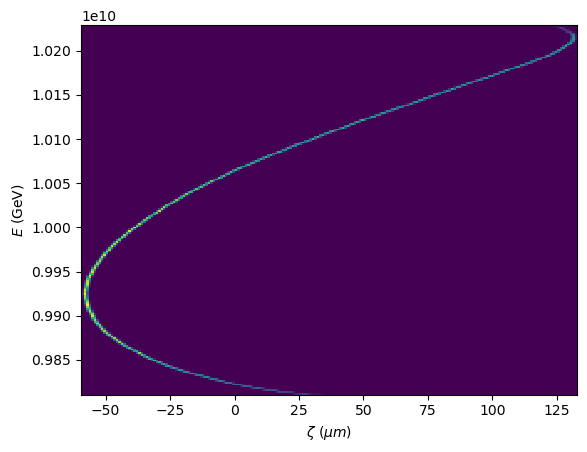

In [82]:
plt.hist2d( -1e6*(testCompression.beam.z - np.mean(testCompression.beam.z) ),  testCompression.beam.energy , 200);
plt.xlabel(r'$\zeta$ ($\mu m$)'); plt.ylabel('$E$ (GeV)');

In [51]:
print(1e3*np.mean(testCompression.beam.x))
print(1e3*np.std(testCompression.beam.x))

0.0017133465184437635
0.09022103065741427


In [52]:
P[-1].energy

array([1.01455448e+10, 1.00692043e+10, 1.01102138e+10, ...,
       1.01322468e+10, 1.01092283e+10, 9.84345063e+09])

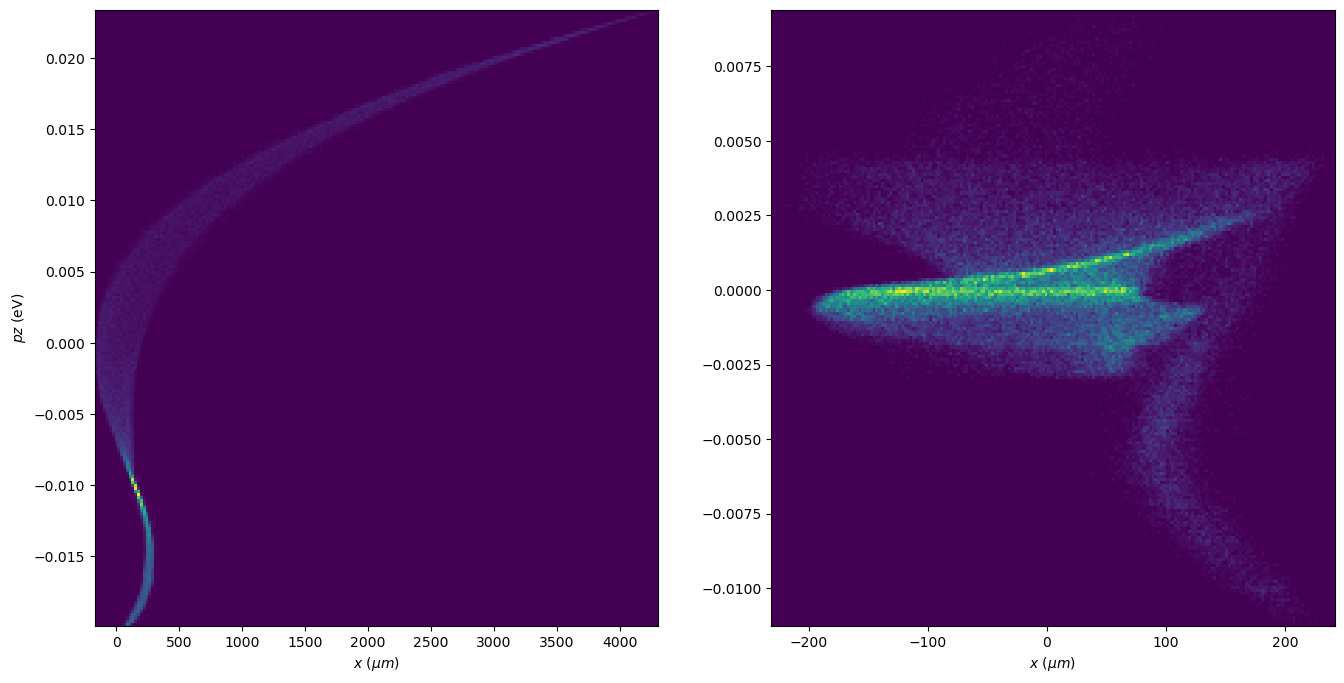

In [53]:
fig, ax  = plt.subplots(1,2, figsize = (16,8) );
ax[0].hist2d( 1e6*P[-1].x,  P[-1].pz/P[-1].pz.mean()-1, 200);
ax[0].set_xlabel(r'$x $ ($\mu m $)'); ax[0].set_ylabel('$pz$ (eV)');
#ax[0].set_xlim(-100, 650); ax[0].set_ylim(-2e5, 3e5); 

ax[1].hist2d(1e6*testCompression.beam.x,  testCompression.beam.pz , 200);
ax[1].set_xlabel(r'$x$ ($\mu m$)'); ax[0].set_ylabel('$pz$ (eV)');
#ax[1].set_xlim(-100, 650); ax[1].set_ylim(-2e5, 3e5); 

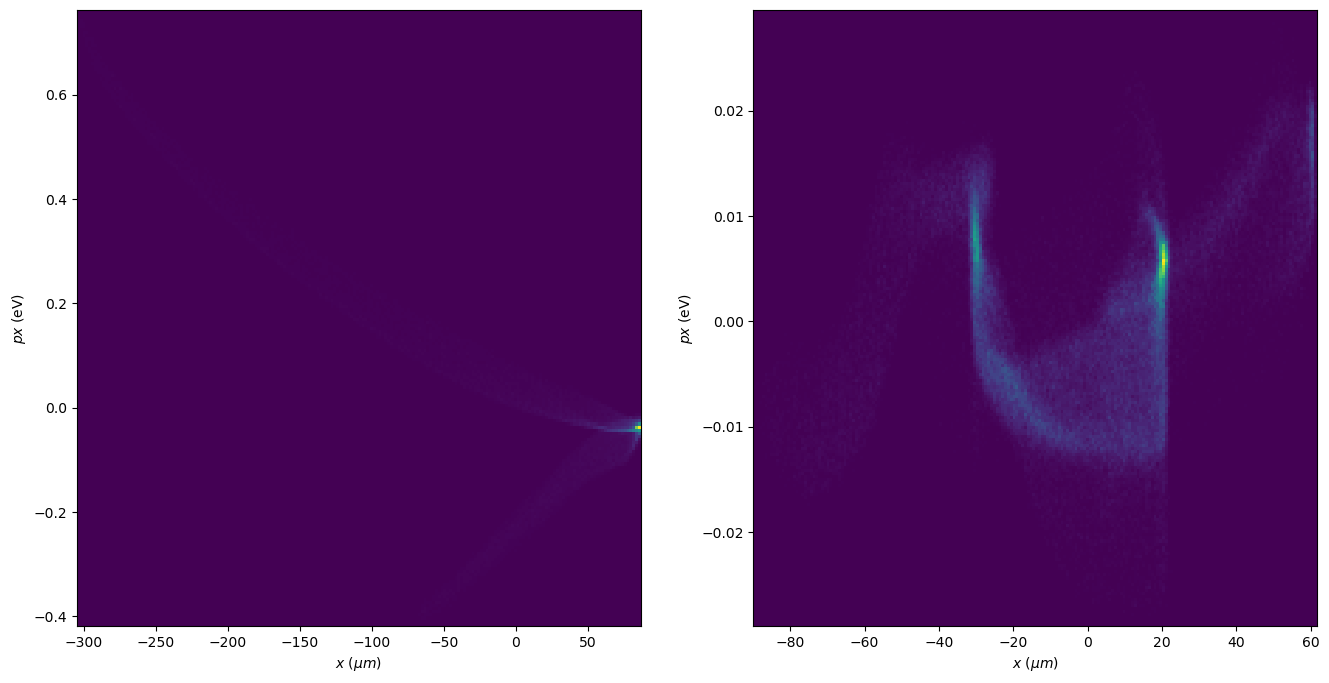

In [56]:
fig, ax  = plt.subplots(1,2, figsize = (16,8) );
ax[0].hist2d( -3e8*1e6*(P[-1].t - P[-1].t.mean()),  1e3*P[-1].px/P[-1].pz.mean(), 200);
ax[0].set_xlabel(r'$x $ ($\mu m $)'); ax[0].set_ylabel('$px$ (eV)');
#ax[0].set_xlim(-100, 650); ax[0].set_ylim(-2e5, 3e5); 

ax[1].hist2d(1e6*(testCompression.beam.z - testCompression.beam.z.mean()),  1e3*testCompression.beam.px , 200);
ax[1].set_xlabel(r'$x$ ($\mu m$)'); ax[1].set_ylabel('$px$ (eV)');
#ax[1].set_xlim(-100, 650); ax[1].set_ylim(-2e5, 3e5); 